# Constopac (RADMC-3D)
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/16/2024          |
| Updated |  12/16/2024          |

## Theoretical Model

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2} \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]} \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right] \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right] \\
\end{align*}

Let $u_\mathrm{init}$ be the initial specific internal energy of the gas.
From the [classical ideal gas law](https://en.wikipedia.org/wiki/Equation_of_state#Classical_ideal_gas_law), in code units,

\begin{align*}
  T_\mathrm{init} &=  (\gamma - 1)u_\mathrm{init} \\
  u_\mathrm{init} &= \frac{P}{\rho(\gamma - 1)}
\end{align*}

h/r (r = L_0) = 0.06 (cf. original h/r_0 = 0.07)

/athinput.[pgen]
<problem>
...
kappa_a = 558.98169599999994  # absorption opacity [\rho_0*L_0]
kappa_a = 21.84 cm^2/g


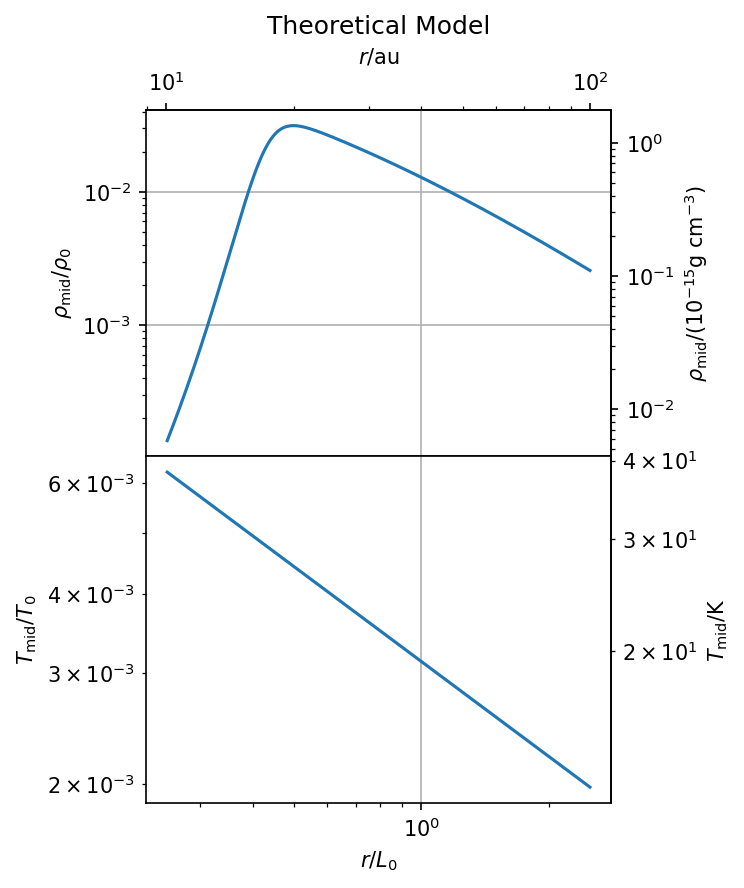

In [1]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# BEGIN /athinput.[pgen]
# <radiation>
T_unit           = 6.14e3              # T_0 [K]
length_unit      = 5.98e14             # L_0 [cm]
density_unit     = 4.28e-14            # \rho_0 [g/cm^3]
molecular_weight = 0.6                 # \mu
# END /athinput.[pgen]

# Solar constants, astrophysical units and conversions
Lsun             = 3.83e33             # solar luminosity [erg/s]
Rsun             = 6.95700e10          # solar radius [cm]
au               = 1.495978707e13      # astronomical unit [cm]
L_au             = length_unit/au      # [au]

# BEGIN [pgen].cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = np.abs(x1*np.sin(x2))
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(rad, phi, z):
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# END [pgen].cpp

# extra quantities
kappa_star_cgs    = 10                 # [cm^2/g]
dgratio           = 100                # dust-to-gas ratio
small_grain_ratio = 0.02184

# begin athinput.[pgen]
# <mesh>
nx1              = 1024                # Number of zones in X1-direction
x1min            = 0.250163663377926   # minimum value of X1
x1max            = 2.501636633779264   # maximum value of X1

nx2              = 128                 # Number of zones in X2-direction
x2min            = 0                   # minimum value of X2
x2max            = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor           = 1e-12               # minimum density

# <problem>
r0               = 0.425278227742474   # disk radial normalization [L_0]
rho0             = 0.2                 # disk density normalization [\rho_0]
p0_over_r0       = 4.80e-03            # (H/r0)^2
pslope           = -0.5                # pressure power-law index
dslope           = -2.25               # density power-law index
kappa_a          = 558.98169599999994  # absorption opacity [\rho_0*L_0]
# end athinput.[pgen]

# Compute dust opacity in code units
kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'h/r (r = L_0) = {(PoverR(1, np.pi/2, 0))**0.5:.2f}'\
      + f' (cf. original h/r_0 = {p0_over_r0**0.5:.2f})\n')
print('/athinput.[pgen]\n<problem>\n...')
print(rf'kappa_a = {kappa_a:.14f}  # absorption opacity [\rho_0*L_0]')
print(rf'kappa_a = {kappa_a/density_unit/length_unit:.2f} cm^2/g')

# Conversions
rad2deg          = 180/np.pi           # [deg]

# Generate fields
x1f, x2f = np.linspace(x1min, x1max, nx1+1), np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rads, phis, zs = GetCylCoord(x1mesh, x2mesh, 0)
rho_field_theo = DenProfileCyl(rads, phis, zs)
rho_field_theo[rho_field_theo < dfloor] = dfloor
T_field_theo = PoverR(rads, phis, zs)
dtheta_theo = (x2max - x2min)/nx2
theta_mid_deg = 90
j_mid = int(theta_mid_deg/rad2deg/dtheta_theo)

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=150)
axs[0].plot(x1v, rho_field_theo[j_mid, :])
axs[1].plot(x1v, T_field_theo[j_mid, :])

# Format secondary axes in cgs
def r2au(r):
  return r*L_au

def rho2cgs(rho):
  return rho*density_unit/1e-15

def T2cgs(T):
  return T*T_unit

ax_r = axs[0].secondary_xaxis('top', functions=(r2au, r2au))
ax_rho = axs[0].secondary_yaxis('right', functions=(rho2cgs, rho2cgs))
ax_T = axs[1].secondary_yaxis('right', functions=(T2cgs, T2cgs))

ax_r.set(xlabel=r'$r$/au')
ax_r.minorticks_on()
ax_rho.set(ylabel=r'$\rho_\mathrm{mid}$/($10^{-15}$g cm$^{-3}$)')
ax_rho.minorticks_on()
ax_T.set(ylabel=r'$T_\mathrm{mid}$/K')
ax_T.minorticks_on()

# Format subplots
for ax in axs:
  ax.set(xscale='log', yscale='log')
  ax.grid()
  ax.minorticks_on()

axs[0].set(title='Theoretical Model', ylabel=r'$\rho_\mathrm{mid}/\rho_0$')
axs[1].set(xlabel=r'$r/L_0$',
           ylabel=r'$T_\mathrm{mid}/T_0$')
plt.subplots_adjust(hspace=0.0)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

## Code comparison

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

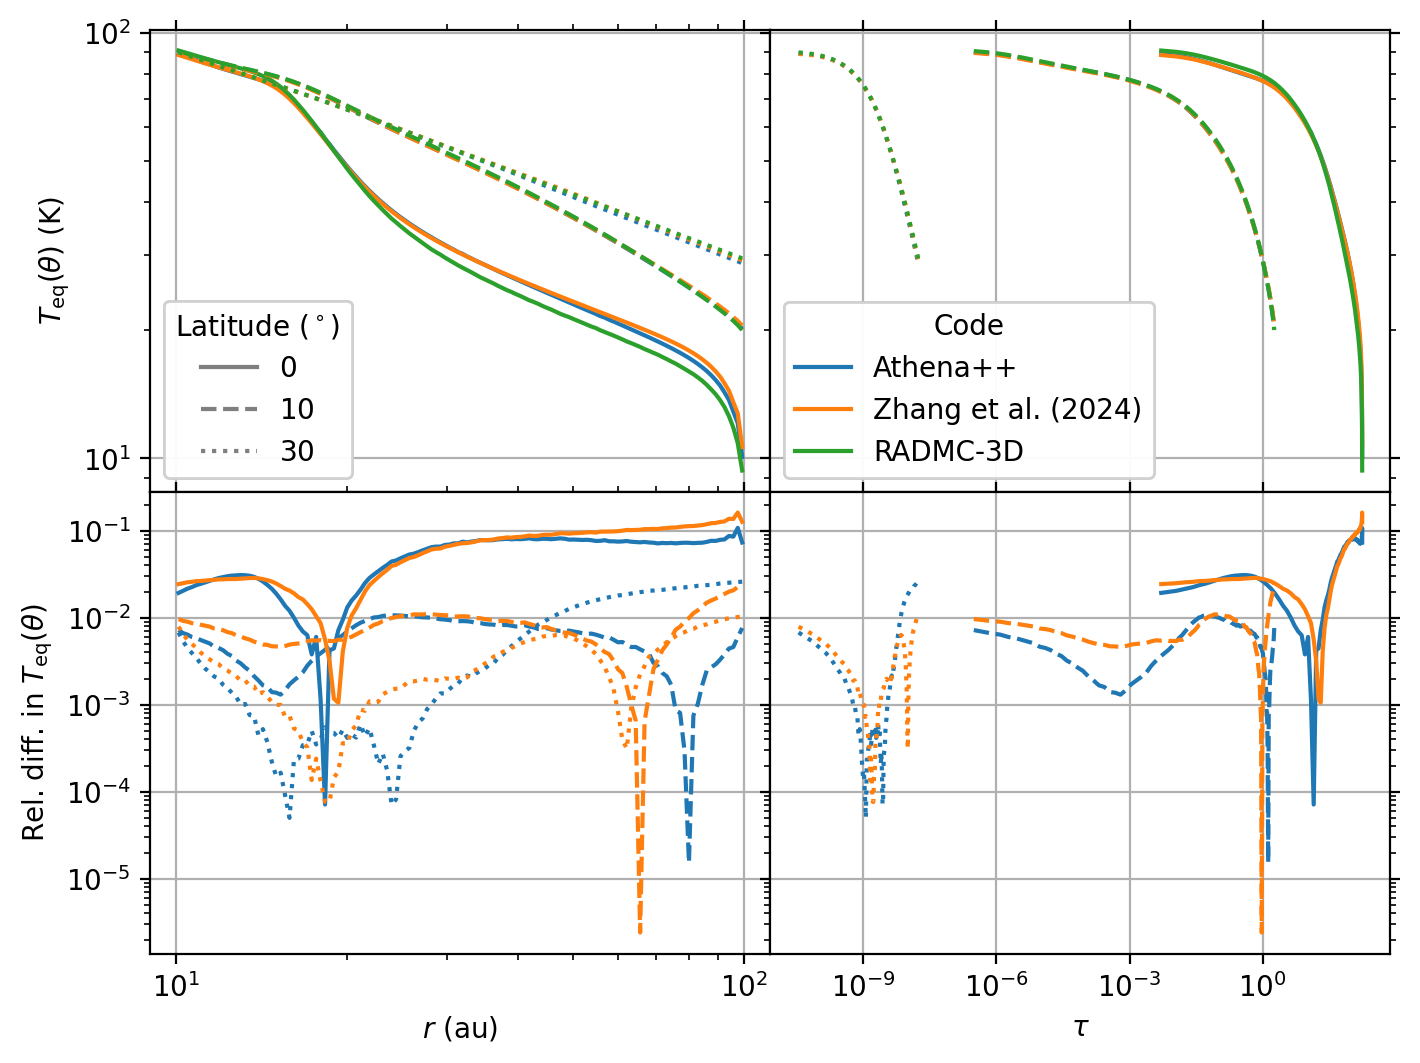

In [1]:
#===============================================================================
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
arad    = 7.565733250033928e-15
c_speed = 2.99792458e10  # // speed of light
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 80, 60]
c_solns, ls_thetas, ref_soln = [], [], []

# RADMC-3D
base = '/home/stanley/github/sabaronett/rad-hydro/radmc3d'
run = 'constopac'
path = f'{base}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']
dtheta = (grid.y[-1] - grid.y[0])/len(grid.y)

# Athena++
problem_id = ['dsharp', 'disk']
output = ['00001', '00100']
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'dsharp_abs-sca/zhang24comp'
runs = ['sab/constopac', 'sz/constopac_updated']
code = ['Athena++', 'Zhang et al. (2024)']
for i, run in enumerate(runs):
  path = f'{base}/{run}'
  if i == 0:
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}')
    length_unit = athinput['radiation']['length_unit']
    T_unit = athinput['radiation']['T_unit']
  else:
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}_sph_rad')
    length_unit = athinput['radiation']['lunit']
    T_unit = athinput['radiation']['Tunit']
  nx1 = athinput['mesh']['nx1']
  nx2 = athinput['mesh']['nx2']
  nzeta = athinput['radiation']['nzeta']
  L_au = length_unit/au
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id[i]}.out1.{output[i]}.athdf')
  dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
  tau = np.cumsum(dtau, axis=1)
  T_field = athdf['press'][0]/athdf['rho'][0]
  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    rel_diff_T = 2*np.abs(T_field[j, :]*T_unit - dusttemp[:,j,0,0])\
                 /(T_field[j, :]*T_unit + dusttemp[:,j,0,0])
    axs[0][0].plot(athdf['x1v']*L_au, T_field[j, :]*T_unit, color=tab_colors[i],
                ls=lss[th])
    axs[1][0].plot(athdf['x1v']*L_au, rel_diff_T, color=tab_colors[i],
                   ls=lss[th])
    axs[0][1].plot(tau[j, :], T_field[j, :]*T_unit, color=tab_colors[i],
                   ls=lss[th])
    axs[1][1].plot(tau[j, :], rel_diff_T, color=tab_colors[i], ls=lss[th])
    if i == 1:
      ls_thetas.append(axs[0][1].plot([], [], color='tab:gray', ls=lss[th],
                       label=rf'${90-theta_deg}$')[0])
      axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color=tab_colors[i+1], ls=lss[th])
      axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color=tab_colors[i+1], ls=lss[th])
  c_solns.append(axs[1][1].plot([], [], color=tab_colors[i],
                 label=f'{code[i]}')[0])
c_solns.append(axs[1][1].plot([], [], color=tab_colors[i+1], label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
ls_legend = axs[0][0].legend(title=r'Latitude ($^\circ)$', handles=ls_thetas)
color_legend = axs[0][1].legend(title=r'Code', handles=c_solns)
# soln_legend = axs[1].legend(handles=ref_soln)
axs[0][0].add_artist(ls_legend)
axs[0][1].add_artist(color_legend)
# axs[1].add_artist(soln_legend)

# Format (sub)plots
for ax in axs.flat:
  ax.grid()
  ax.minorticks_on()
  ax.set(xscale='log', yscale='log')
  ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)', ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau$')
# fig.suptitle(r'$\kappa_{\nu,f}^\mathrm{abs+sca}$', y=0.92)
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('gray_absorption.pdf', bbox_inches='tight', pad_inches=0.01)